In [1]:
import random
import math
import matplotlib.pyplot as plt
import time
import numpy as np
from point import Point

Same pool of trials for all participants (static), with different shuffling (dynamic).

---

# Static Layout Pool
This refers to the generation of the layout pool, which will be the same for ALL participants.

Original V3 notebook written by Sinan Yumurtaci. 

Updates for the V4 by Paisley Annes and Derek J. Huffman: here, fewer layouts (25) and we added the door as an additional constraint to avoid having the participant trigger arrival at an object when opening the door into a nearby object.

## Generation

- Given N trials, we produce  N/2 pairs of layouts.
    - Between these pairs, we keep the same coordinates for the points, and the same order of navigation.
    - One of these pairs is the no-boundary-show, the other is the boundary-shown. The layout is rotated between these two.
    - Per layout, we have 5 objects and an ending location. The first object is also the starting location and might be asked.
    - We do not want any 2 objects to be too close to each other.
    - We do not want any path to be too short. We do not have an upper bound on the travel distance.
    - We want to to make sure that there is at least one object on both sides.

In [2]:
N_POINTS_LAYOUT = 4 # 3 objects, one of which is the starting location, and an ending location
N_LAYOUTS = 25 # generate this many layouts. each layout produces a pair (visible/invisible boundary)

# these are currently arbitrary units that we can scale up and down as needed
# w=5, l=10 represents a 1 by 2 rectangle room
WIDTH = 7.5  # 5 
LENGTH = 10
# the door is approximately 1 vm, but let's say 1.5 for some padding
DOOR_WIDTH = 1.5

ASPECT = LENGTH / WIDTH

# this is the minimum distance any two objects (not a path) can have. 
# used to prevent objects appearing too close and confusing participants
MIN_DIST_OBJECTS = 2.5 #1.5

# this is the minimum path distance. no subsequent object should appear closer than this.
# greater than MIN_DIST_OBJECTS because objects appearing too close also means they are visited too soon and not enough time to learn that object
MIN_DIST_PATH = 3.5 #2.3

In [3]:
def generate_random_layout():
    return [Point.random_rect(WIDTH, LENGTH) for p in range(N_POINTS_LAYOUT)]

def has_valid_margin(p):
    # checks if a given point p is within a valid margin from the boundaries 
    # and borders of the rectangle defined by WIDTH and LENGTH
    buffer = 0.05
    x_lo = buffer * WIDTH
    x_hi = (1 - buffer) * WIDTH
    
    y_lo = buffer * LENGTH
    y_hi = (1 - buffer) * LENGTH
    
    border_lo = (LENGTH / 2) - LENGTH * buffer
    border_hi = (LENGTH / 2) + LENGTH * buffer

    # Additional constraint for the centerline semi-circle
    #door_radius = DOOR_WIDTH / 
    # set center_x to be offset, like the environment
    center_x = WIDTH - DOOR_WIDTH #WIDTH / 2
    center_y = LENGTH / 2

    # Check if the point is outside the semi-circle
    door_constraint = not ((p.x - center_x)**2 + (p.y - center_y)**2 < DOOR_WIDTH**2 and center_y - DOOR_WIDTH < p.y < center_y + DOOR_WIDTH)
    
    
    bufferFromBoundary = (x_lo < p.x < x_hi) and (y_lo < p.y < y_hi)
    bufferFromBorder = not (border_lo < p.y < border_hi)
    
    return bufferFromBoundary and bufferFromBorder and door_constraint

def is_valid_layout(lay):
    
    # check all distance constraints, (dist between objects and path distances)
    for i in range(len(lay)):
        for j in range(i):
            # if these points are adjacent, check for path distance condition, otherwise object distance condition
            lower_bound = MIN_DIST_PATH if j == i - 1 else MIN_DIST_OBJECTS
            if lay[i].dist(lay[j]) <= lower_bound:
                return False
    
    # check that there is at least one object on each side
    # note that this checks for objects ONLY (that is; not the last point which is the ending/task location)
    objects_on_lower_side = sum([1 if l.y < LENGTH / 2 else 0 for l in lay[:N_POINTS_LAYOUT-1]])
    if not ( 1 <= objects_on_lower_side < N_POINTS_LAYOUT-1):
        # either 0 or N_POINTS_LAYOUT-1 on this side, which means the reverse for the other side. not valid!
        return False
    
    for p in lay:
        if not has_valid_margin(p):
            return False
    
    return True

def generate_valid_layout():
    # generates a valid layout by repeatedly calling generate_random_layout() 
    # until a layout is found that satisfies the conditions
    candidate = generate_random_layout()
    c = 0
    while not is_valid_layout(candidate):
        c += 1
        if c == 1e5:
            print("can not find valid layout!")
            return None
        candidate = generate_random_layout()
    return candidate

In [4]:
layouts = []
for l in range(N_LAYOUTS):
    layouts.append(generate_valid_layout())

In [5]:
print(layouts)

[[P(3.34, 1.5), P(2.76, 6.13), P(6.59, 7.36), P(0.99, 2.77)], [P(6.51, 8.57), P(4.99, 3.41), P(3.64, 9.41), P(5.18, 0.85)], [P(6.56, 7.1), P(3.45, 2.89), P(3.68, 7.87), P(6.25, 2.15)], [P(4.88, 0.87), P(6.79, 6.63), P(0.63, 8.44), P(1.88, 1.67)], [P(4.73, 0.79), P(1.25, 9.49), P(0.46, 1.36), P(5.45, 8.68)], [P(0.43, 5.65), P(7.01, 2.14), P(6.45, 8.05), P(2.49, 8.38)], [P(1.82, 7.66), P(3.82, 0.89), P(5.3, 6.94), P(6.62, 3.63)], [P(5.5, 1.83), P(2.23, 3.67), P(5.8, 7.0), P(0.65, 0.63)], [P(1.75, 2.4), P(5.25, 0.52), P(2.0, 7.35), P(5.95, 8.66)], [P(0.68, 8.98), P(1.3, 0.85), P(3.86, 8.49), P(0.89, 4.08)], [P(5.91, 9.05), P(4.11, 4.5), P(6.8, 0.85), P(2.62, 8.94)], [P(0.91, 2.91), P(4.4, 5.82), P(3.78, 1.58), P(5.09, 8.96)], [P(6.4, 2.74), P(7.02, 7.64), P(1.92, 1.23), P(4.53, 9.17)], [P(0.54, 9.09), P(1.11, 2.6), P(1.78, 6.37), P(6.59, 8.86)], [P(0.89, 8.5), P(5.75, 1.98), P(4.02, 6.98), P(0.45, 5.93)], [P(4.9, 1.13), P(1.66, 8.12), P(3.16, 3.66), P(5.37, 7.83)], [P(4.55, 9.14), P(2.31,

## Checks
- We want to check for the following distributions:
    - Pointing ground-truths -> compare those in the same side and across the boundary.
    - How much they have traveled
    - Distances between any two objects
    
- And the following are nice sanity checks to have:
    - Plot of all layouts
    - Plot of all points

In [6]:
# Ground Truth for Pointing Tasks (GTPT)
gtpt_same = []
gtpt_cross = []
gtpt_path = []

for lay in layouts:
    last = lay[-1]
    last_side = last.y < LENGTH / 2
    
    for obj_index, obj in enumerate(lay[:-1]):
        is_on_same_side = last_side == (obj.y < LENGTH / 2)
        dist = last.dist(obj)
        if is_on_same_side:
            gtpt_same.append(dist)
        else:
            gtpt_cross.append(dist)
            # path distance
            mid_point = Point(WIDTH - 0.1, LENGTH / 2)
            full_dist = lay[obj_index].dist(mid_point) + mid_point.dist(last)
            gtpt_path.append(full_dist)

gtpt_all = [gtpt_same, gtpt_cross, gtpt_path]
print(len(gtpt_same), "same side; ", len(gtpt_cross), "across boundary")

30 same side;  45 across boundary


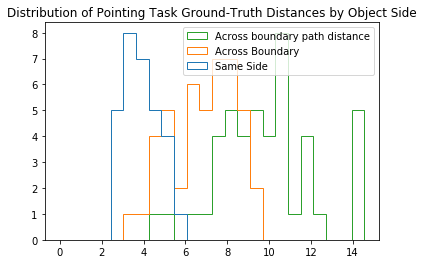

In [7]:
plt.hist(gtpt_all, bins = 24, range = [0, max(gtpt_same + gtpt_cross + gtpt_path)] ,histtype='step', stacked=False, fill=False, label = ["Same Side", "Across Boundary", "Across boundary path distance"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Pointing Task Ground-Truth Distances by Object Side")
plt.show()

In [8]:
# Travel Distance (TD)
# Note: this shows the travel distance between each pair of points
# this is interesting/important, but we likely care more about the distance from end point to other points (see above)

td_same = []
td_cross_real = []
td_cross_bird = []

for lay in layouts:
    for i in range(len(lay) - 1):
        prev_side = lay[i].y < LENGTH / 2
        next_side = lay[i+1].y < LENGTH / 2
        is_on_same_side = prev_side == next_side
        if is_on_same_side:
            td_same.append(lay[i].dist(lay[i+1]))
        else:
            #mid_point = Point(WIDTH / 2, LENGTH / 2)
            # changing to have the door on the right side of the environment
            mid_point = Point(WIDTH - 0.1, LENGTH / 2)
            full_dist = lay[i].dist(mid_point) + mid_point.dist(lay[i+1])
            td_cross_real.append(full_dist)
            td_cross_bird.append(lay[i].dist(lay[i+1]))
        
td_all = [td_same, td_cross_real, td_cross_bird]
print(len(td_same), "same side; ", len(td_cross_real), "across boundary")

19 same side;  56 across boundary


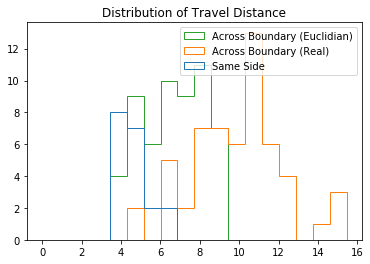

In [9]:
plt.hist(td_all, bins = 18, range = [0, max(td_same + td_cross_real + td_cross_bird)], histtype='step', stacked=False, fill=False, label = ["Same Side", "Across Boundary (Real)", "Across Boundary (Euclidian)"])
plt.legend(prop={'size': 10})
plt.title("Distribution of Travel Distance")
plt.show()

In [10]:
# Object Distance (OD)
od_all = []

for lay in layouts:
    for i in range(len(lay)):
        for j in range(i):
            od_all.append(lay[i].dist(lay[j]))

print(f"{len(od_all)} object distances")

150 object distances


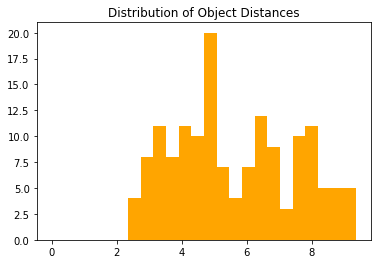

In [11]:
plt.hist(od_all, bins = 24, range = [0, max(od_all)], color = "orange")
plt.title("Distribution of Object Distances")
plt.show()

C:\Users\derek\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


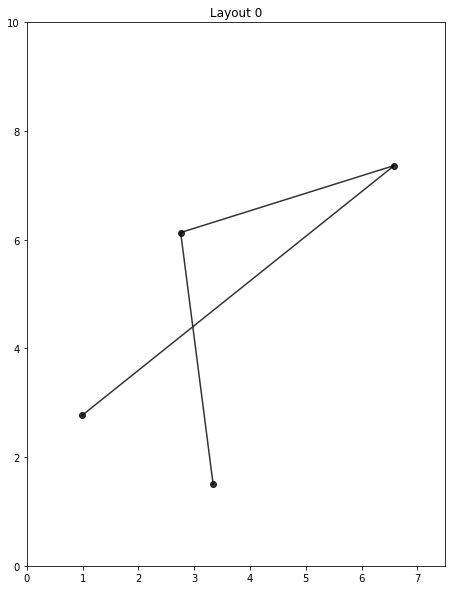

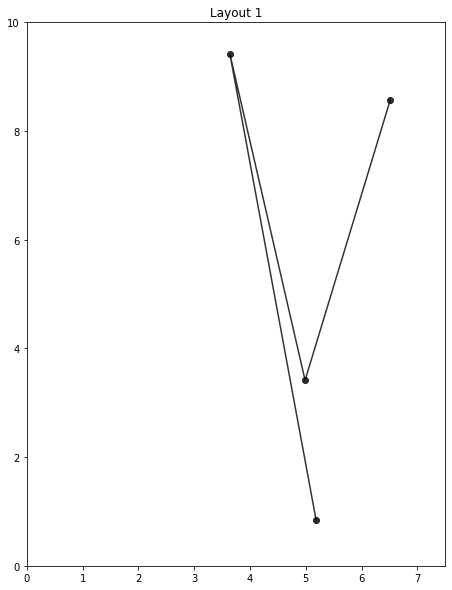

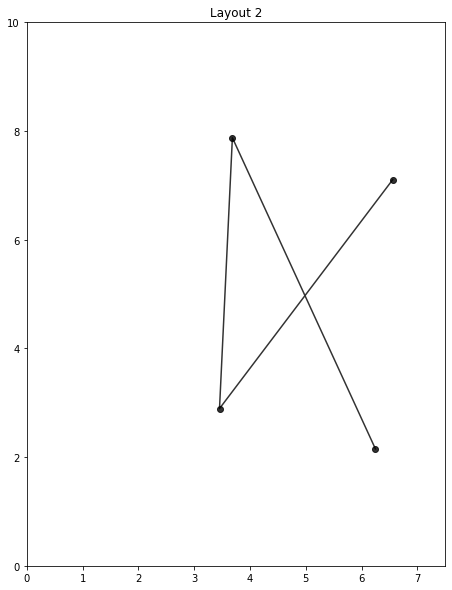

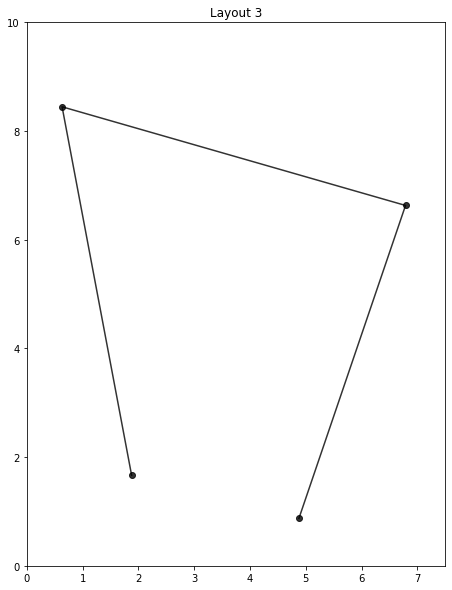

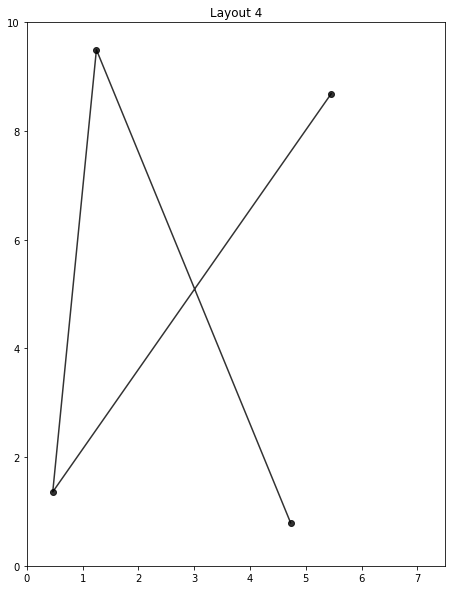

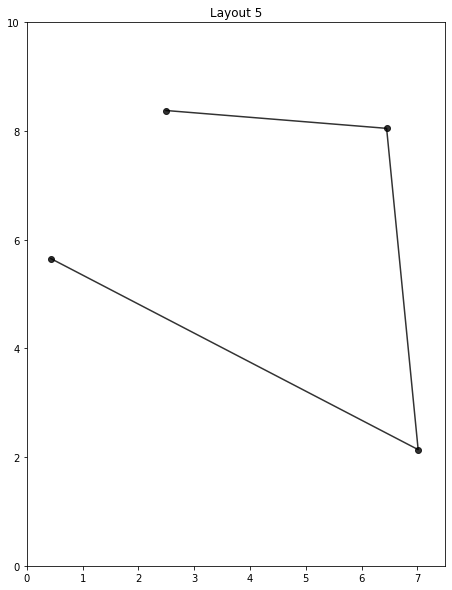

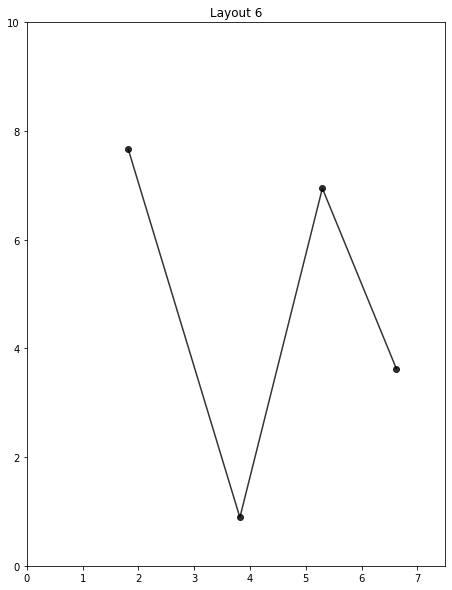

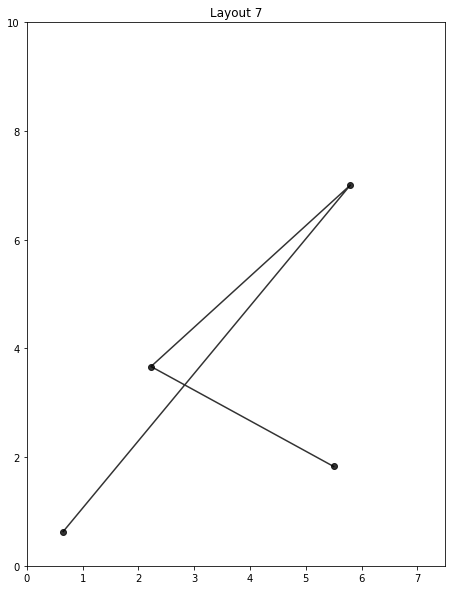

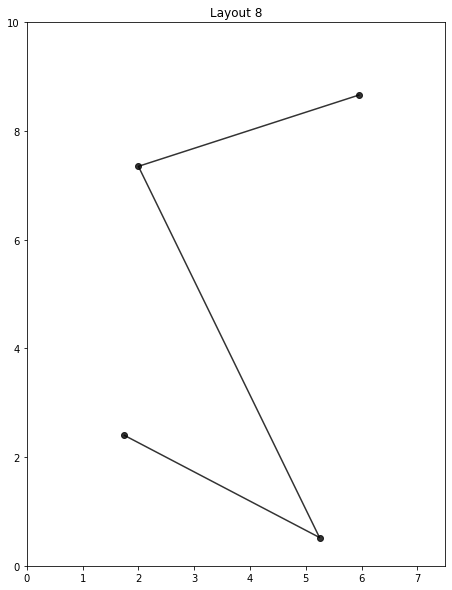

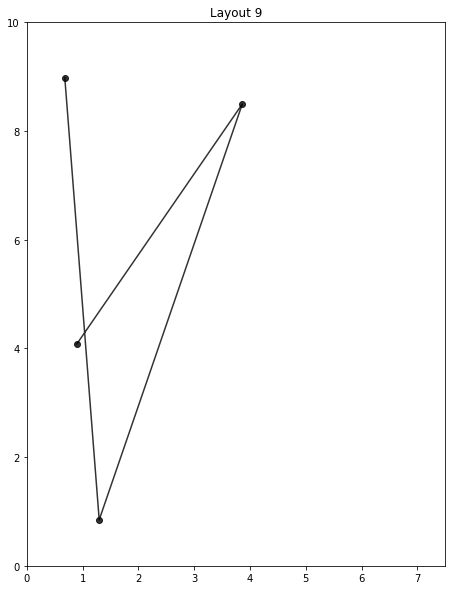

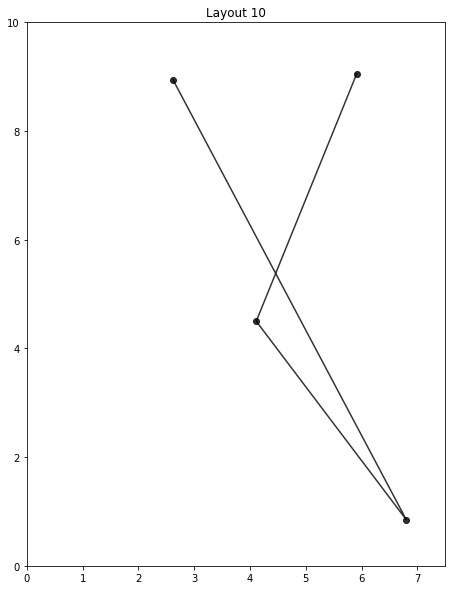

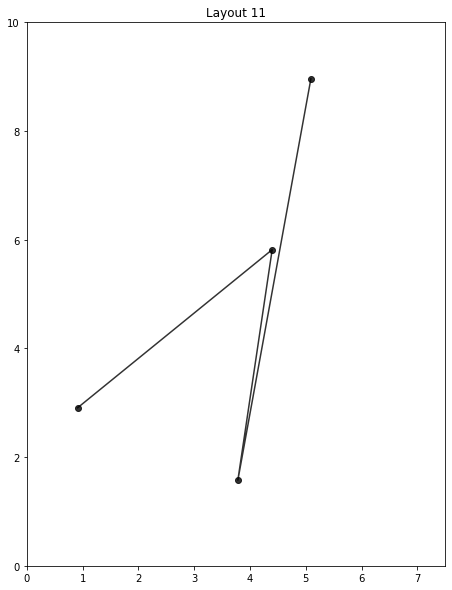

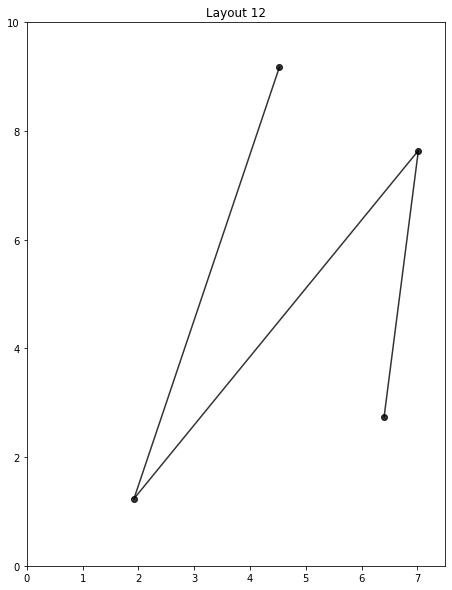

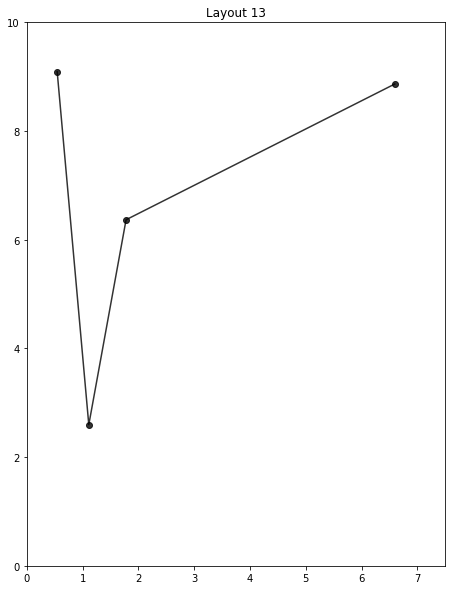

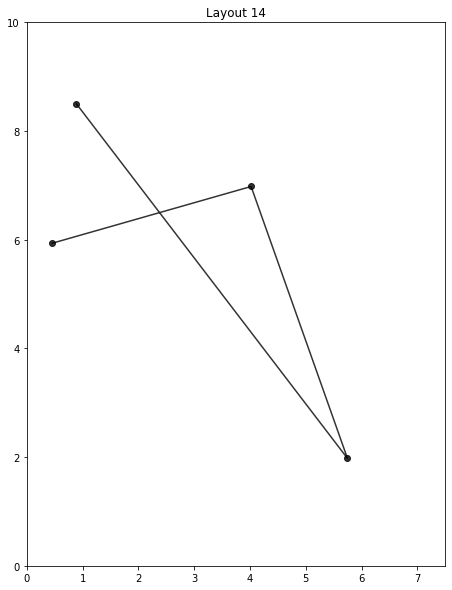

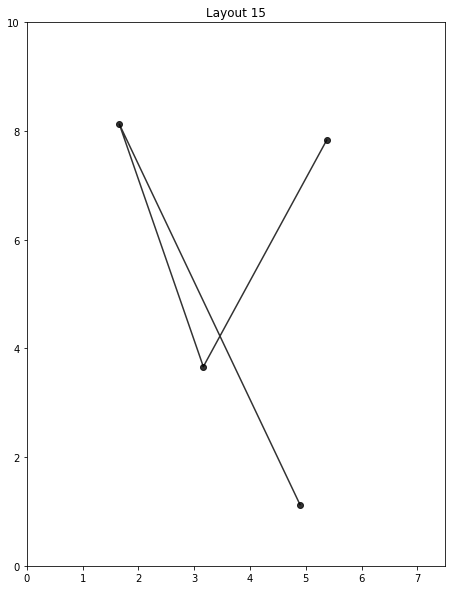

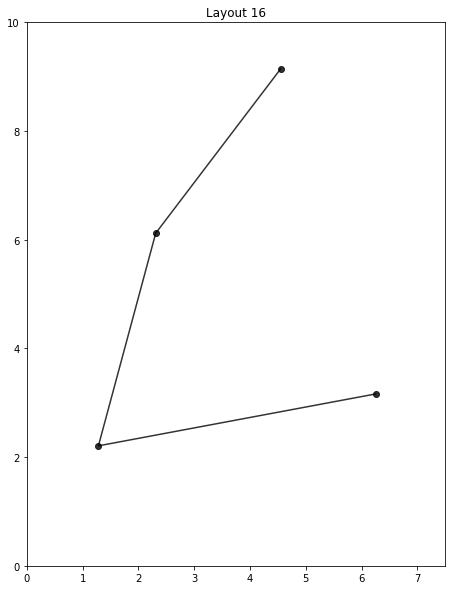

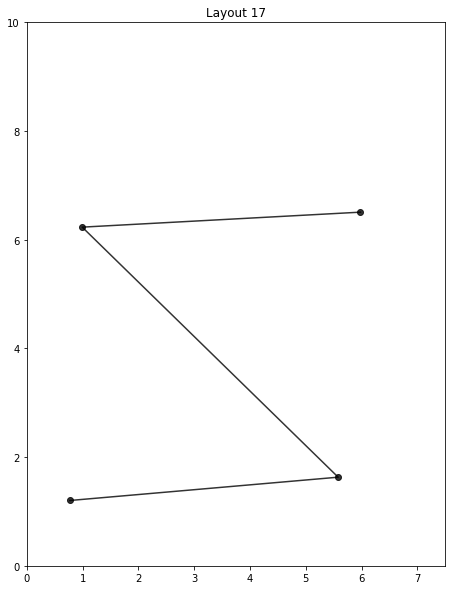

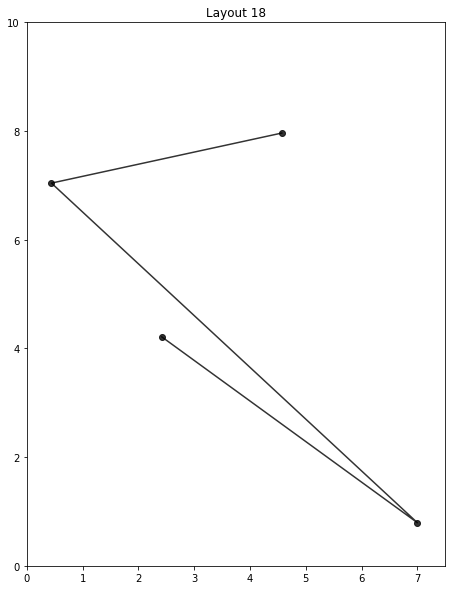

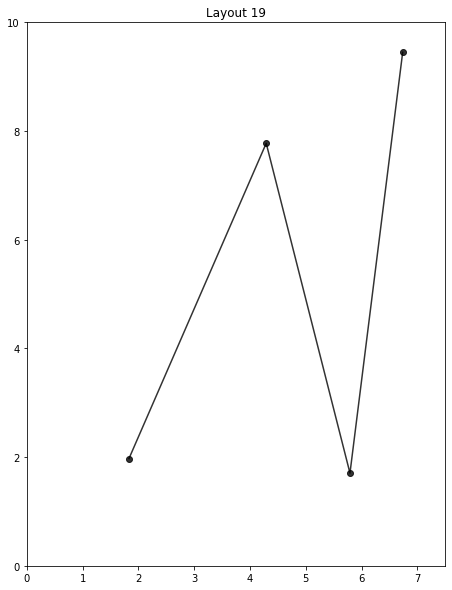

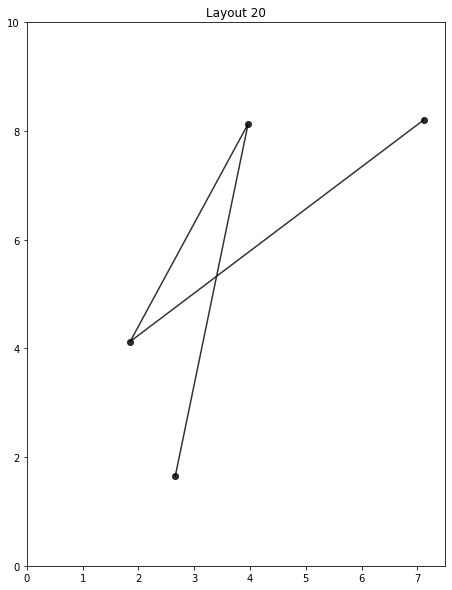

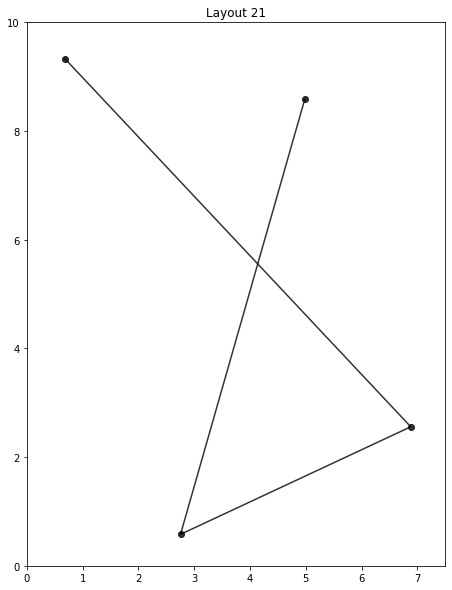

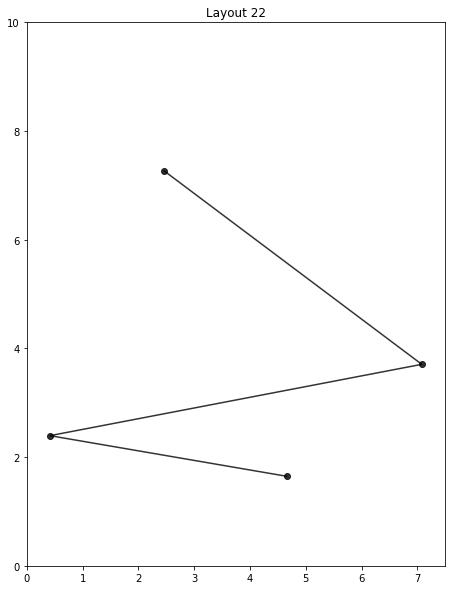

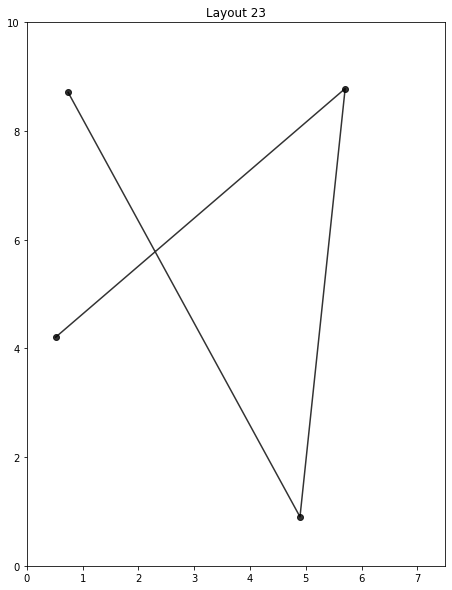

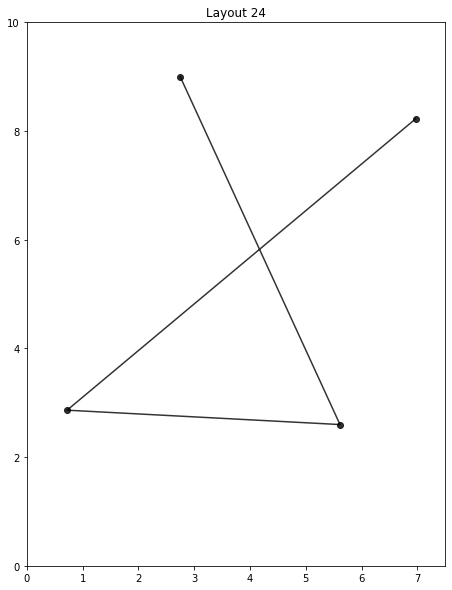

In [12]:
for i, lay in enumerate(layouts):
    fig, axs = plt.subplots(figsize = (7.5, 10))
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.8)
    plt.xlim([0, WIDTH])
    plt.ylim([0, LENGTH])
    plt.title(f"Layout {i}")

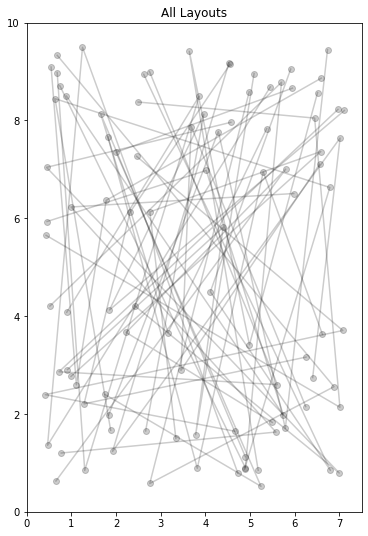

In [13]:
fig, axs = plt.subplots(figsize = (6, 9))
for lay in layouts:
    plt.plot([p.x for p in lay], [p.y for p in lay], "k-o", alpha = 0.2)
plt.title("All Layouts")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

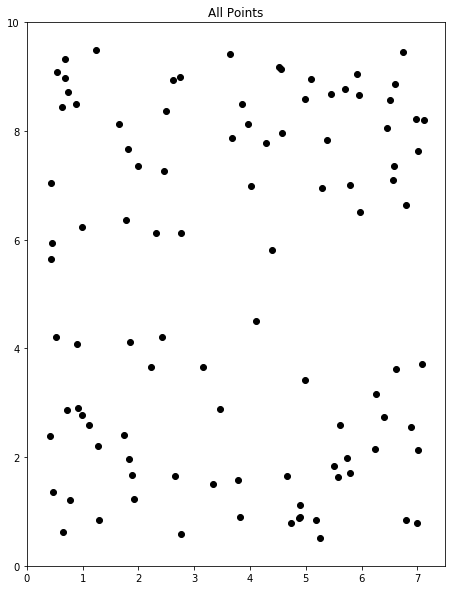

In [14]:
fig, axs = plt.subplots(figsize = (7.5, 10))
for lay in layouts:
    plt.scatter([p.x for p in lay], [p.y for p in lay], color = "k")
plt.title("All Points")
plt.xlim([0, WIDTH])
plt.ylim([0, LENGTH])
plt.show()

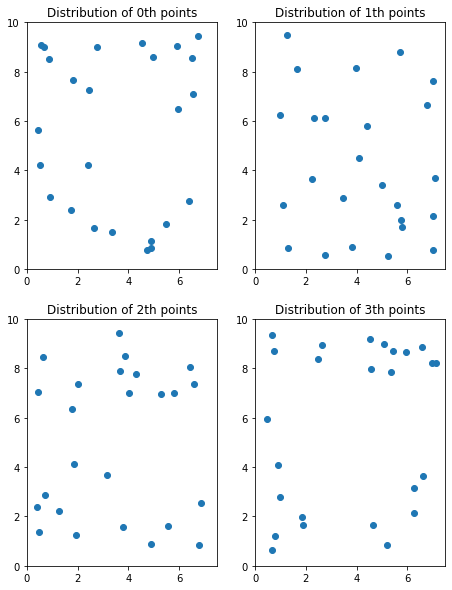

In [15]:
# Distribution of different points in a layout sequence
fig, axs = plt.subplots(2, 2, figsize = (7.5, 10))
for i in range(N_POINTS_LAYOUT):
    ith_ps = [layouts[j][i] for j in range(N_LAYOUTS)]
    xs, ys = [p.x for p in ith_ps], [p.y for p in ith_ps]
    axs[i//2, i%2].scatter(xs, ys)
    axs[i//2, i%2].set_xlim([0, WIDTH])
    axs[i//2, i%2].set_ylim([0, LENGTH])
    axs[i//2, i%2].set_title(f"Distribution of {i}th points")

# Objects
Sinan had coded the object/color mapping to be totally random. The issue with this approach is that we can get multiple objects of the same color or shape in a given trial. I (DJH) think that it will be better to set the condition that within each trial they see one of every shape and one of every color, which will help make things more distinct within a trial. 

So, our conditions:
1. Unique colors + shapes on each trial.
2. No repeats of colors within the past trial.
3. We will still keep Sinan's criterion of no repeats of exact object (color + shape) within the past N targets, but we will increase that number to 12 (i.e., 4 trials).

In [16]:
OBJ_COLORS = ["red", "orange", "yellow", "green", "cyan", "purple", "white", "blue"]
#OBJ_SHAPES = ["capsule", "cube", "cylinder", "sphere"]
OBJ_SHAPES = ["capsule", "cube", "sphere"]
OBJ = [c + "_" + s for s in OBJ_SHAPES for c in OBJ_COLORS]
"  ".join(OBJ)

'red_capsule  orange_capsule  yellow_capsule  green_capsule  cyan_capsule  purple_capsule  white_capsule  blue_capsule  red_cube  orange_cube  yellow_cube  green_cube  cyan_cube  purple_cube  white_cube  blue_cube  red_sphere  orange_sphere  yellow_sphere  green_sphere  cyan_sphere  purple_sphere  white_sphere  blue_sphere'

In [17]:
OBJ

['red_capsule',
 'orange_capsule',
 'yellow_capsule',
 'green_capsule',
 'cyan_capsule',
 'purple_capsule',
 'white_capsule',
 'blue_capsule',
 'red_cube',
 'orange_cube',
 'yellow_cube',
 'green_cube',
 'cyan_cube',
 'purple_cube',
 'white_cube',
 'blue_cube',
 'red_sphere',
 'orange_sphere',
 'yellow_sphere',
 'green_sphere',
 'cyan_sphere',
 'purple_sphere',
 'white_sphere',
 'blue_sphere']

In [18]:
def generate_objects_trial(n_obj_per_trial=N_POINTS_LAYOUT-1):
    trial_colors = np.random.permutation(OBJ_COLORS)[:n_obj_per_trial].tolist()
    trial_shapes = np.random.permutation(OBJ_SHAPES)[:n_obj_per_trial]
    trial_obj = [trial_colors[i] + "_" + trial_shapes[i] for i in range(n_obj_per_trial)]
    return trial_obj, trial_colors

In [19]:
generate_objects_trial()

(['yellow_capsule', 'cyan_cube', 'white_sphere'], ['yellow', 'cyan', 'white'])

In [20]:
NUM_OBJ = (N_POINTS_LAYOUT - 1) * N_LAYOUTS * 2 # x2 because we do each layout twice (w/ and w/o border)
objects = [] # objects[i] is the the i % (N_POINTS_LAYOUT - 1)th object in the i // N_LAYOUTS layout (simply a list of objects in order of appereance)
colors = []
#for i in range(NUM_OBJ):
#    random_obj = random.choice(OBJ)
#    while random_obj in objects[-10:]: # same object shouldn't appear 10 targets apart!
#        random_obj = random.choice(OBJ)
#    objects.append(random_obj)
for trial_i in range(N_LAYOUTS * 2):
    trial_obj, trial_colors = generate_objects_trial()
    #while np.any([np.any(trial_obj[x] in objects[-12:]) for x in range(len(trial_obj))]):
    while np.any([np.any(trial_obj[x] in objects[-12:]) or np.any(trial_colors[x] in colors[-3:]) for x in range(len(trial_obj))]): # same object shouldn't appear 10 targets apart!
        trial_obj, trial_colors = generate_objects_trial()
    objects.extend(trial_obj)
    colors.extend(trial_colors)

len(objects), objects[:10]

(150,
 ['red_sphere',
  'orange_capsule',
  'cyan_cube',
  'green_capsule',
  'blue_cube',
  'yellow_sphere',
  'cyan_sphere',
  'red_capsule',
  'orange_cube',
  'green_sphere'])

In [21]:
objects

['red_sphere',
 'orange_capsule',
 'cyan_cube',
 'green_capsule',
 'blue_cube',
 'yellow_sphere',
 'cyan_sphere',
 'red_capsule',
 'orange_cube',
 'green_sphere',
 'purple_capsule',
 'white_cube',
 'cyan_capsule',
 'orange_sphere',
 'yellow_cube',
 'green_cube',
 'white_capsule',
 'red_sphere',
 'cyan_cube',
 'yellow_capsule',
 'purple_sphere',
 'white_sphere',
 'blue_cube',
 'red_capsule',
 'purple_cube',
 'green_capsule',
 'yellow_sphere',
 'blue_capsule',
 'white_cube',
 'orange_sphere',
 'cyan_sphere',
 'purple_capsule',
 'red_cube',
 'blue_sphere',
 'white_capsule',
 'orange_cube',
 'red_sphere',
 'cyan_cube',
 'yellow_capsule',
 'purple_sphere',
 'orange_capsule',
 'blue_cube',
 'white_sphere',
 'cyan_capsule',
 'green_cube',
 'yellow_sphere',
 'red_capsule',
 'purple_cube',
 'orange_cube',
 'blue_sphere',
 'white_capsule',
 'green_capsule',
 'red_cube',
 'cyan_sphere',
 'purple_sphere',
 'blue_cube',
 'yellow_capsule',
 'green_cube',
 'cyan_capsule',
 'white_sphere',
 'purple_cu

In [22]:
len(objects)

150

# Save Data
- These will be shuffled by the v4_dynamic notebook

In [23]:
import json

layout_out = {"width": WIDTH, "length": LENGTH, "layouts": [[[p.x, p.y] for p in lay] for lay in layouts], "objects": objects}
with open("data/static_layout_pool_25.json", "w") as outfile:
    outfile.write(json.dumps(layout_out))